## Metric 1b: Annual mean daily wildfire PM2.5 concentration
Uses Year-Round Data (Not just Wildfire Season Months)

In [1]:
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime, timedelta 
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [2]:
current_directory = os.path.dirname(os.getcwd())
current_directory

'/mnt/c/Users/nrathauda/OneDrive - University of Alaska/NIMHD K01 - wildfire and birth outcomes/Alaska_wildfire-smoke-metrics_2025'

### Load Data Files

In [3]:
# Daily Averaged WFS PM2.5 data by Census Tract
relative_path = "Output/Daily_Average_WFS_PM25_by_Census_Tract.csv"
grouped_data_path = os.path.join(current_directory, relative_path)
PM25_by_Tracts_WFS = pd.read_csv(grouped_data_path)

# Census Tracts Shapefile
relative_sf_path = "Raw_Data/Shapefiles/Tracts2020.shp"
grouped_data_CT_path = os.path.join(current_directory, relative_sf_path)
Tracts2020 = gpd.read_file(grouped_data_CT_path)
Tracts2020 = Tracts2020.to_crs(epsg=3338) # NAD AK Albers projection (better to project maps of AK only)

### Calculate Annual Daily Wildfire PM2.5 Concentration

In [4]:
# Ensure Date is in datetime format
PM25_by_Tracts_WFS['Date'] = pd.to_datetime(PM25_by_Tracts_WFS['Date'])
PM25_by_Tracts_WFS['Year'] = PM25_by_Tracts_WFS['Date'].dt.year

In [5]:
# Calculate average PM2.5 by Census Tract
averages_by_year_and_tract = PM25_by_Tracts_WFS.groupby(['Year', 'NAME'])['PM2.5'].mean().reset_index()
WFS_M1b_Year_Tract = averages_by_year_and_tract.pivot(index='NAME', columns='Year', values='PM2.5')

In [6]:
# Create an average of all the raw data for each tract
average_pm25_by_name = PM25_by_Tracts_WFS.groupby('NAME')['PM2.5'].mean().reset_index()
average_pm25_by_name.rename(columns={'PM2.5': 'average_across_years'}, inplace=True)

# Ensure NAME is the index in both DataFrames for alignment
average_pm25_by_name.set_index('NAME', inplace=True)

# Append the average_across_years column to WFS_M1b_Year_Tract
WFS_M1b_Year_Tract['average_across_years'] = average_pm25_by_name['average_across_years']

# Sort the tracts by the average PM2.5
WFS_M1b_Year_Tract = WFS_M1b_Year_Tract.round(2)
WFS_M1b_Year_Tract.head()

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,average_across_years
NAME,,,,,,,,,,,,,,,,,,,
Abbott Loop,0.34,0.92,1.20,0.19,0.25,0.36,1.14,0.45,0.40,0.29,0.64,1.09,0.87,0.34,0.42,0.29,3.47,0.22,0.72
Abbott Loop North,0.34,0.92,1.20,0.19,0.25,0.36,1.14,0.45,0.40,0.29,0.64,1.09,0.87,0.34,0.42,0.29,3.47,0.22,0.72
Abbott Loop West,0.34,0.92,1.20,0.19,0.25,0.36,1.14,0.45,0.40,0.29,0.64,1.09,0.87,0.34,0.42,0.29,3.47,0.22,0.72
Airport Heights,0.34,0.92,1.20,0.19,0.25,0.36,1.14,0.45,0.40,0.29,0.64,1.09,0.87,0.34,0.42,0.29,3.47,0.22,0.72
Airport Way Central,1.18,20.57,4.71,0.94,0.72,0.48,4.95,2.03,1.24,1.01,1.94,0.63,4.53,0.51,0.72,0.92,3.94,0.34,2.85


In [7]:
# Export
relative_mean_daily_path = "Output/WFS_M1b_annual_averages_full_year_census_tracts.csv"
mean_daily_path = os.path.join(current_directory, relative_mean_daily_path)
WFS_M1b_Year_Tract.to_csv(mean_daily_path, index=False)

# Data Visualization

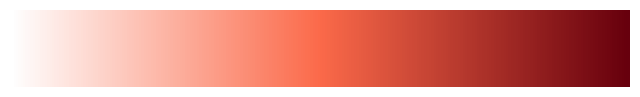

In [8]:
# Define colors: White -> Bright Red -> Deep Dark Red
colors = ["white", "#FB6A4A", "#67000D"]  # Bright red (#FB6A4A) from Reds at ~midpoint
WhiteToRed = mcolors.LinearSegmentedColormap.from_list("WhiteToBrightToDarkRed", colors)

# Test colormap with a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=WhiteToRed)
ax.set_axis_off()
plt.show()

In [9]:
# Maps Output Folder Path
relative_output_file_path = "Output"
output_folder = os.path.join(current_directory, relative_output_file_path)

## Individual Maps

In [10]:
# Define the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)

# Exclude 'average_across_years' and 'NAME'
years_to_plot = [year for year in WFS_M1b_Year_Tract.columns if year not in ['average_across_years', 'NAME']]

# Merge the census data with the entire WFS_M1b_Year_Tract
WFS_M1b_Annual_Tract_wGeo = Tracts2020.merge(WFS_M1b_Year_Tract, on='NAME', how='inner')

# Set vmin and vmax based on the overall data
vmin = 0
vmax = WFS_M1b_Annual_Tract_wGeo[years_to_plot].max().max()  # Find the overall maximum across all years

# Generate tick positions for colorbar
ticks = np.arange(0, vmax + 5, 5)

# Iterate over each year
for year in years_to_plot:
    # Create a figure and GeoAxes with the Albers Equal Area projection
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': alaska_albers}, figsize=(8, 6))
    
    # Plotting the shapefile with a color based on Avg_PM25 values for the specific year
    WFS_M1b_Annual_Tract_wGeo.plot(ax=ax, column=year, cmap=WhiteToRed, transform=alaska_albers, 
                                  legend=False, vmin=vmin, vmax=vmax)
    
    # Add thin black border to the shapefile data
    WFS_M1b_Annual_Tract_wGeo.boundary.plot(ax=ax, color='black', linewidth=0.25, transform=alaska_albers)
    
    # Set plot title
    ax.set_title(f"{year}", fontsize=14)
    
    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')  # Remove frame around the map

    # Add a colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToRed),
                        ax=ax, orientation='horizontal', fraction=0.036, pad=0.1, ticks=ticks)
    cbar.set_label(r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', fontsize=12)
    
    # Save the individual map to the output folder
    output_file_path = f"{output_folder}/WFS_PM25_Map_{year}.png"
    plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
    
    # Close the figure to save memory
    plt.close(fig)

print("All individual maps have been saved to:", output_folder)

All individual maps have been saved to: /mnt/c/Users/nrathauda/OneDrive - University of Alaska/NIMHD K01 - wildfire and birth outcomes/Alaska_wildfire-smoke-metrics_2025/Output


## Panel Map

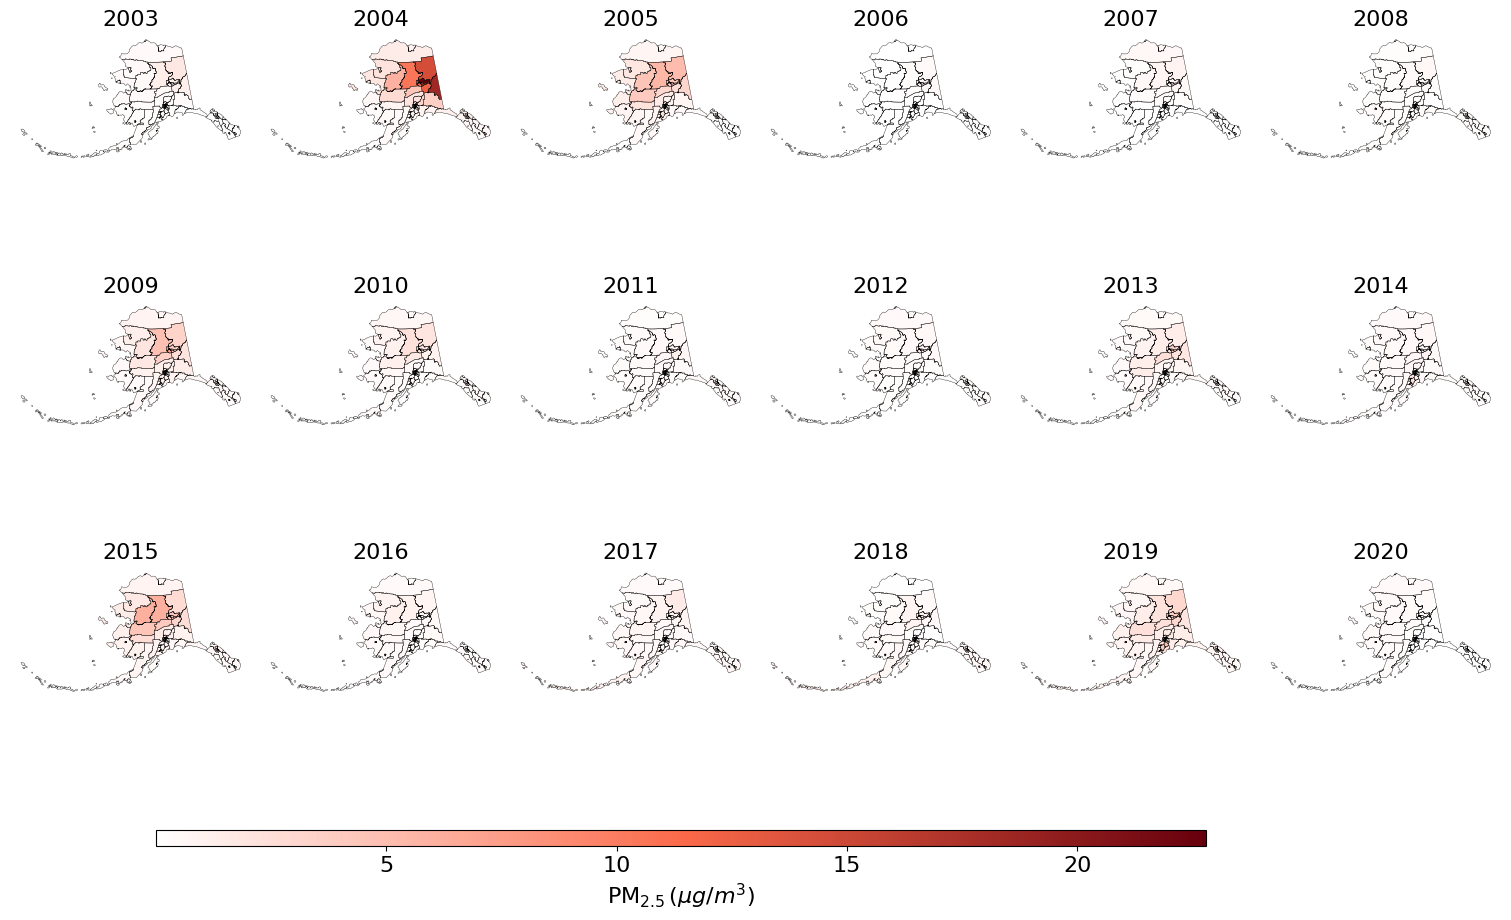

In [13]:
# Number of rows and columns for the panel
num_rows = 3
num_cols = 6

# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': alaska_albers}, figsize=(15, 8), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Excluding 'average_across_years' and 'NAME'
years_to_plot = [year for year in WFS_M1b_Year_Tract.columns if year not in ['average_across_years', 'NAME']]

# Merge the census data with the entire WFS_M1b_Year_Tract
WFS_M1b_Annual_Tract_wGeo = Tracts2020.merge(WFS_M1b_Year_Tract, on='NAME', how='inner')

# Iterate over each year
for i, year in enumerate(years_to_plot):
    # Set vmin and vmax based on the current year's data
    vmin = 0
    vmax = WFS_M1b_Annual_Tract_wGeo[years_to_plot].max().max()  # Find the overall maximum across all years

    # Plotting the shapefile with a color based on Avg_PM25 values for the specific year
    WFS_M1b_Annual_Tract_wGeo.plot(ax=axes[i], column=year, cmap=WhiteToRed, transform=alaska_albers, legend=False, vmin=vmin, vmax=vmax)

    # Add thin black border to the shapefile data
    WFS_M1b_Annual_Tract_wGeo.boundary.plot(ax=axes[i], color='black', linewidth=0.25, transform=alaska_albers)

    # Set plot title
    axes[i].set_title(f"{year}", fontsize=16)

    # Remove axes ticks and labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

    # Remove frame around each subplot
    axes[i].axis('off')
    
# Generate tick positions for colorbar
ticks = np.arange(0, vmax + 5, 5)

# Generate a single colorbar for all plots
cbar_ax = fig.add_axes([0.1, -0.1, 0.7, 0.02])  # Adjust the width of the colorbar here
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToRed),
                    cax=cbar_ax, orientation='horizontal', ticks=[5,10,15,20])
cbar.set_label(r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', fontsize=16)  # Increase title size
cbar_ax.tick_params(labelsize=16)  # Increase tick label size

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export the image, ensuring tight layout so the colorbar isn't cut off
output_file_path = f"{output_folder}/WFS_M1b_Panel.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Show the figure in the notebook
plt.show()

## Cumulative Map

Single map using data across entire study period

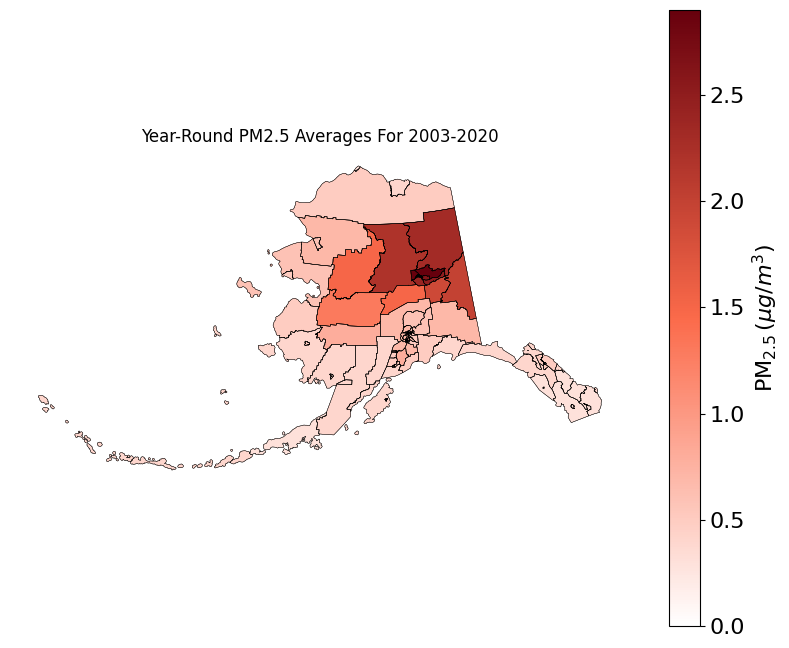

In [12]:
# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

# Merge the census data with the WFS_M1_Year_Tract DataFrame
WFS_M1b_Cummul_Tract_wGeo_Full = Tracts2020.merge(average_pm25_by_name, on='NAME', how='inner')

# Set vmin and vmax 
vmin = 0
vmax = WFS_M1b_Cummul_Tract_wGeo_Full['average_across_years'].max()

# Plotting the shapefile
WFS_M1b_Cummul_Tract_wGeo_Full.plot(ax=ax, column='average_across_years', cmap=WhiteToRed, transform=alaska_albers, legend=False, vmin=vmin, vmax=vmax)

# Add thin black border to the shapefile data
WFS_M1b_Cummul_Tract_wGeo_Full.boundary.plot(ax=ax, color='black', linewidth=0.25, transform=alaska_albers)

# Variable handling
WFS_M1b_Cummul_Tract_wGeo_Full.columns = WFS_M1b_Cummul_Tract_wGeo_Full.columns.astype(str)

# Round
WFS_M1b_Cummul_Tract_wGeo_Full['average_across_years'] = WFS_M1b_Cummul_Tract_wGeo_Full['average_across_years'].round(1)

# Set vmin and vmax based on the 'average_across_years' data
vmin = 0
vmax = WFS_M1b_Cummul_Tract_wGeo_Full['average_across_years'].max()

# Plot the shapefile data with a custom legend title
WFS_M1b_Cummul_Tract_wGeo_Full.plot(
    ax=ax,
    column='average_across_years',
    cmap=WhiteToRed,
    transform=alaska_albers,
    legend=True,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={'label': r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', 'orientation': "vertical"}
)

# Colorbar label text sizing
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel(r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', fontsize=16)  # Increase title size
cbar.tick_params(labelsize=16)  # Increase tick label size

# Add thin black border to the shapefile data
WFS_M1b_Cummul_Tract_wGeo_Full.boundary.plot(ax=ax, color='black', linewidth=0.25, transform=alaska_albers)

# Remove box around map
fig, ax = plt.gcf(), plt.gca()
ax.axis('off')

# Export the image
output_file_path = f"{output_folder}/WFS_M1b_Cummulative.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Map title
ax.set_title('Year-Round PM2.5 Averages For 2003-2020')

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export the image
output_file_path = f"{output_folder}/WFS_M1b_Cummulative_Titled.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Show the figure in the notebook
plt.show()